In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd


from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 150,                   
    "grid.alpha": 0.4,                    
})

# Quark Matter


Now with the complete code to add the quark masses later

In [92]:
def number_density(N_d, mu, mass):
    z = mass / mu
    factor = N_d * mu**3 / (6 * np.pi**2)
    if z == 0.0:
        return factor # MeV^3
    else:
        return factor * (1 - z**2)**(3/2) # dimension of mu_q^3


def pressure_f(N_c, mu_q, m_q):
    z_q = m_q / mu_q
    factor  = N_c * mu_q**4 / (24 * np.pi**2)
    
    if z_q == 0.0:
        return factor
    else: 
        term1 = (1-z_q**2)**(1/2)* (1-5/2 * z_q**2)
        term2 = 3/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
        return factor * (term1 + term2) # dimension of mu_q^4

def energy_f(N_c, mu_q, m_q):
    z_q = m_q / mu_q
    factor  = N_c * mu_q**4 / (8 * np.pi**2)

    if z_q == 0.0:
        return factor
    else: 
        term1 = (1-z_q**2)**(1/2)* (1-1/2 * z_q**2)
        term2 = -1/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
        return factor * (term1 + term2) # dimension of mu_q^4
    


$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad \mu' = \frac{\mu}{(4B)^{1/4}} \qquad n' = \frac{n}{(4B)^{3/4}} \qquad M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$

In [93]:
#for massless quarks
m_u = 0.0 # MeV
m_d = 0.0 # MeV
m_s = 0.0 # MeV
m_e = 0.0  # MeV


In [94]:
# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density(6 ,mu_u, m_u)
    nd = number_density(6, mu_d, m_d)
    ns = number_density(6, mu_s, m_s)
    ne = number_density(2, mu_e, m_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]
    

In [95]:
minimum_nb = 0.24750508309523
maximum_nb = 10

list_nb = np.linspace(minimum_nb, maximum_nb, int(1e5))
list_failed_nb = []


grid_e_quark = []
grid_p_quark = []
guess = [2, 2]  # Initial guess for mu_u and mu_e

for nB in list_nb:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d
    guess = [mu_u, mu_e]  # Update guess for next iteration

    #print(f"nB={nB:.3e} fm^-3 -> mu_u={mu_u:.3f}, mu_d={mu_d:.3f}, mu_s={mu_s:.3f}, mu_e={mu_e:.3f}")
    nu = number_density(6 ,mu_u, m_u)
    nd = number_density(6, mu_d, m_d)
    ns = number_density(6, mu_s, m_s)
    ne = number_density(2, mu_e, m_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e}")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e}")


    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - 1/4
    
    if pressure_total < 0:
        print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + 1/4


    grid_e_quark.append(energy_total) # MeV^4
    grid_p_quark.append(pressure_total) # MeV^4




list_nb_1 = list_nb[len(list_failed_nb):]
print("Number of points in EOS with positive pressure:", len(list_nb_1))
print("Failed points (negative pressure):", len(list_failed_nb))


Number of points in EOS with positive pressure: 100000
Failed points (negative pressure): 0


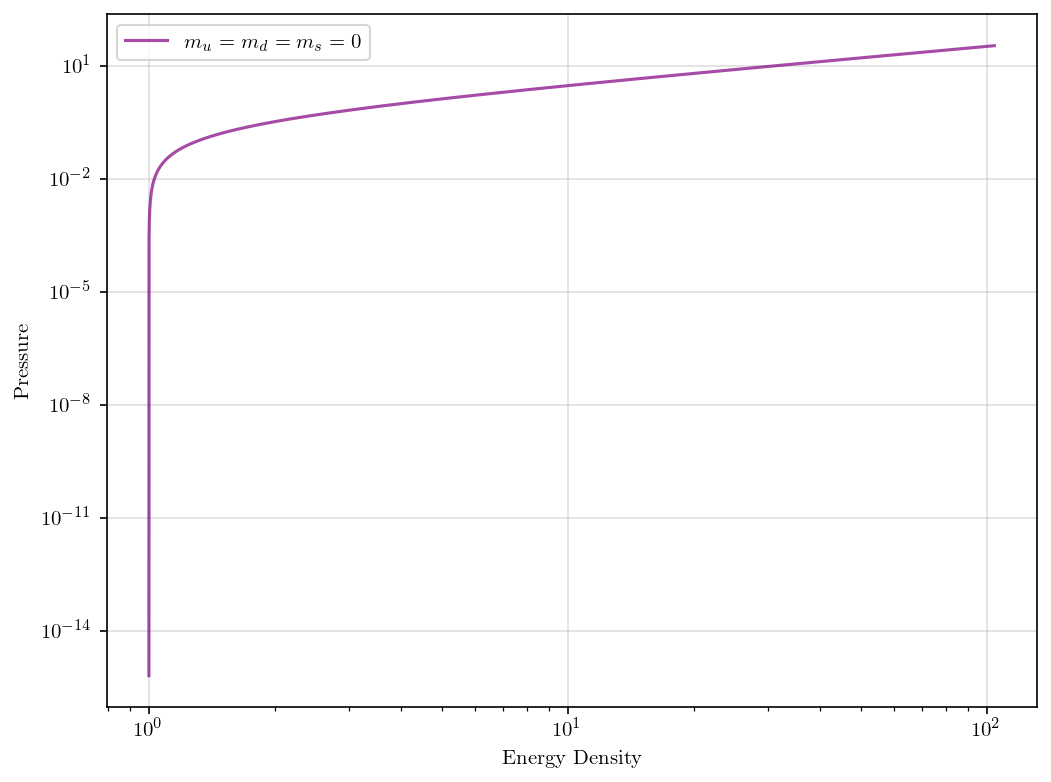

In [96]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(grid_e_quark, grid_p_quark, 
        label='$m_u = m_d = m_s=  0$', color='purple', alpha=0.7)


plt.xlabel('Energy Density')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Pressure')
plt.grid()
plt.legend()

In [ ]:
#save in a csv
eos_data = {
    "nB (fm^-3)": list_nb_1,
    "Energy Density": grid_e_quark,
    "Pressure": grid_p_quark
}
eos_df = pd.DataFrame(eos_data)
eos_df.to_csv("../Data/EOS_MIT_Massless_quarks.csv", index=False)


# Dark Matter


Equation of state in dimensionless units
$$
\epsilon'' = {p''} ^{2/n} + \frac{n+2}{n-2}p''
$$

Before reescaling to the MIT, must recover MeV units:

$$
\varepsilon_0 = \lambda (n/2 +1) m_b ^n \qquad \varepsilon = \varepsilon_0  \varepsilon'' \qquad p = \varepsilon_0  p''
$$

$$
\varepsilon ' =\frac{\varepsilon_0  \varepsilon''}{4B}\qquad p ' =\frac{\varepsilon_0  p''}{4B}
$$



In [98]:
lamb = 1  # coupling strength
m_b = 200 # MeV
n = 4

epsilon_0 = lamb * ( n / 2 - 1) * m_b ** n  # MeV^4
B = 145 **4 # MeV^4


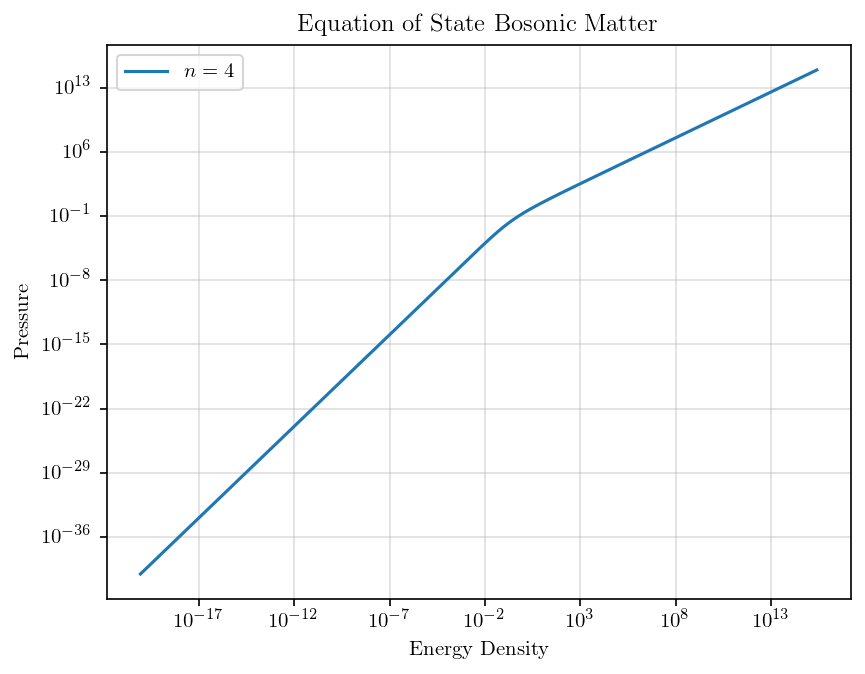

In [99]:
def energy_density(pressure, n):
    return pressure ** (2/n) + ((n + 2) / (n - 2)) * pressure


grid_p_DM = np.logspace(-40, 15, int(1e5)) * epsilon_0 / (4* B)
grid_e_DM = energy_density(grid_p_DM, 4) * epsilon_0 / (4* B)

#plot the eos
plt.plot(grid_e_DM, grid_p_DM,  label=f'$n={n}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Pressure')
plt.xlabel('Energy Density')
plt.title('Equation of State Bosonic Matter')


plt.legend()
plt.grid()
plt.show()

In [100]:
#save csv
eos_data_DM = {
    "Energy Density": grid_e_DM,
    "Pressure": grid_p_DM
}
eos_df_DM = pd.DataFrame(eos_data_DM)
eos_df_DM.to_csv("../Data/EOS_Bosonic_DM_n4_mb200.csv", index=False)

# Two fluids

In [101]:

# ----------------------------------------------------
# 1. ODE Definition 
# ----------------------------------------------------
def ode_TOV(r, x):
    p1, M1, p2, M2 = x
    
    p1_phys = max(0.0, p1)
    p2_phys = max(0.0, p2) # Treat negative pressure as 0 for physics

    if p1_phys > 0:
        e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
    else:
        e1 = 0.0
        
    if p2_phys > 0:
        e2 = np.interp(p2_phys, grid_p_DM, grid_e_DM)
    else:
        e2 = 0.0
    
    M = M1 + M2

    if r < 1e-9:
        return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

    term1_q = (e1 + p1_phys)
    term1_dm = (e2 + p2_phys)
    term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
    term3 = 1 - 2 * M / r

    if term3 <= 1e-9: # negative or zero, horizon reached
        return [0, 0, 0, 0]

    factor = - (M / r**2) / term3

    # Fluid 1 (Quark)
    if p1 <= 0: # If raw pressure is negative, stop contribution
        dp1dr = -1.0
        dM1dr = 0.0 
    else:
        dp1dr = factor * term1_q * term2
        dM1dr = 4 * np.pi * r**2 * e1

    # Fluid 2 (Dark Matter)
    if p2 <= 0: # If raw pressure is negative, stop contribution
        dp2dr = -1.0
        dM2dr = 0.0
    else:
        dp2dr = factor * term1_dm * term2
        dM2dr = 4 * np.pi * r**2 * e2

    return [dp1dr, dM1dr, dp2dr, dM2dr]

# ----------------------------------------------------
# 2. Events 
# ----------------------------------------------------

# Event Quark Surface (do not stop)
def event_Quark_surface(r, x):
    return x[0]
event_Quark_surface.terminal = False 
event_Quark_surface.direction = -1

# Event DM Surface (do not stop)
def event_DM_surface(r, x):
    return x[2]
event_DM_surface.terminal = False
event_DM_surface.direction = -1

# Event C: Stop Integration
def event_Stop_Integration(r, x):
    return max(x[0], x[2])
event_Stop_Integration.terminal = True
event_Stop_Integration.direction = -1


In [102]:
# ----------------------------------------------------
# 3. Solve
# ----------------------------------------------------

#Initial conditions
hc = 197.3269804 # MeV fm
r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, grid_e_quark, grid_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, grid_p_DM, grid_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

sol = solve_ivp(
    ode_TOV, 
    (r0, 1e12), 
    x0, 
    events=[event_Quark_surface, event_DM_surface, event_Stop_Integration],     # [0]=Quark, [1]=DM, [2]=Stop
    rtol=1e-8, 
    atol=1e-10,
    first_step=1e-7 
)

# ----------------------------------------------------
# 4. Solutions
# ----------------------------------------------------

r_adim = sol.t.copy()
p1_adim = sol.y[0].copy()
m1_adim = sol.y[1].copy()
p2_adim = sol.y[2].copy()
m2_adim = sol.y[3].copy()

# --- EXTRACT EXACT RADII FROM EVENTS ---
# sol.t_events is a list containing the R values for each event function.
# Index [0] corresponds to event_Quark_surface
# Index [1] corresponds to event_DM_surface

# 1. Quark Matter Handling
if len(sol.t_events[0]) > 0:
    R_quark_final = sol.t_events[0][0] # Take the first crossing
    print(f"Quark Surface detected at R = {R_quark_final:.4e}")
    
    # Clean up: Force pressure to 0 for all r > R_surface
    # This replaces the manual index search
    p1_adim[r_adim > R_quark_final] = 0.0
else:
    R_quark_final = None
    print("Quark pressure never crossed zero (or started at 0).")

# 2. Dark Matter Handling
if len(sol.t_events[1]) > 0:
    R_DM_final = sol.t_events[1][0] # Take the first crossing
    print(f"DM Surface detected at    R = {R_DM_final:.4e}")
    
    # Clean up: Force pressure to 0 for all r > R_surface
    p2_adim[r_adim > R_DM_final] = 0.0
else:
    R_DM_final = None
    print("DM pressure never crossed zero (or started at 0).")


# ----------------------------------------------------
# 5. Unit Conversions & Plotting
# ----------------------------------------------------
M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B


R_km = r_adim * factor_R_to_km
P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar
P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar


Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   3.54914682e+04
Central mass DM:     1.48666314e-13
Quark Surface detected at R = 1.9350e-03
DM Surface detected at    R = 6.1889e-01


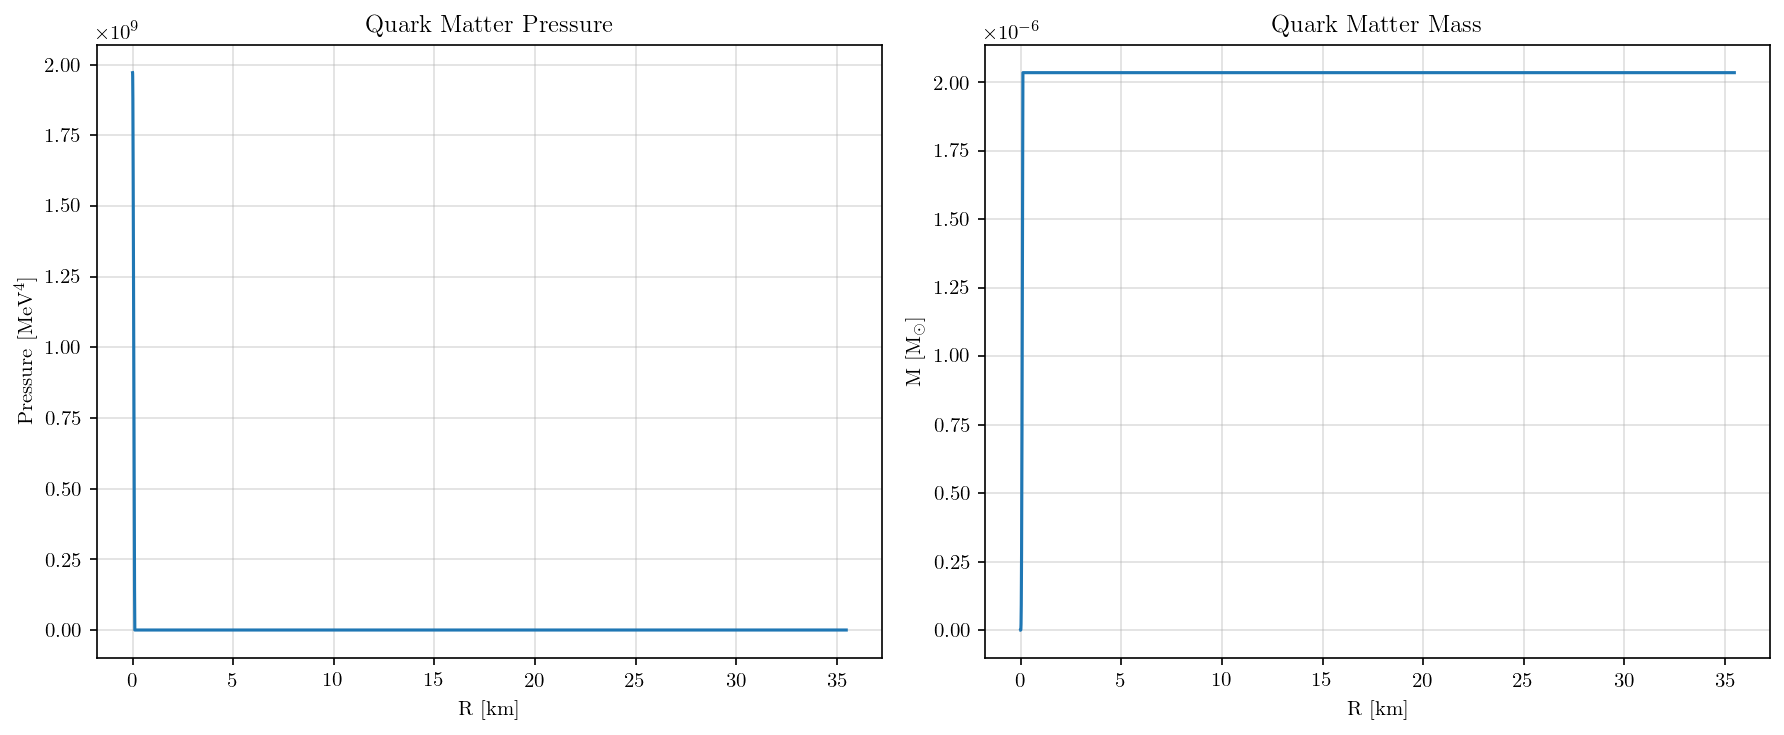

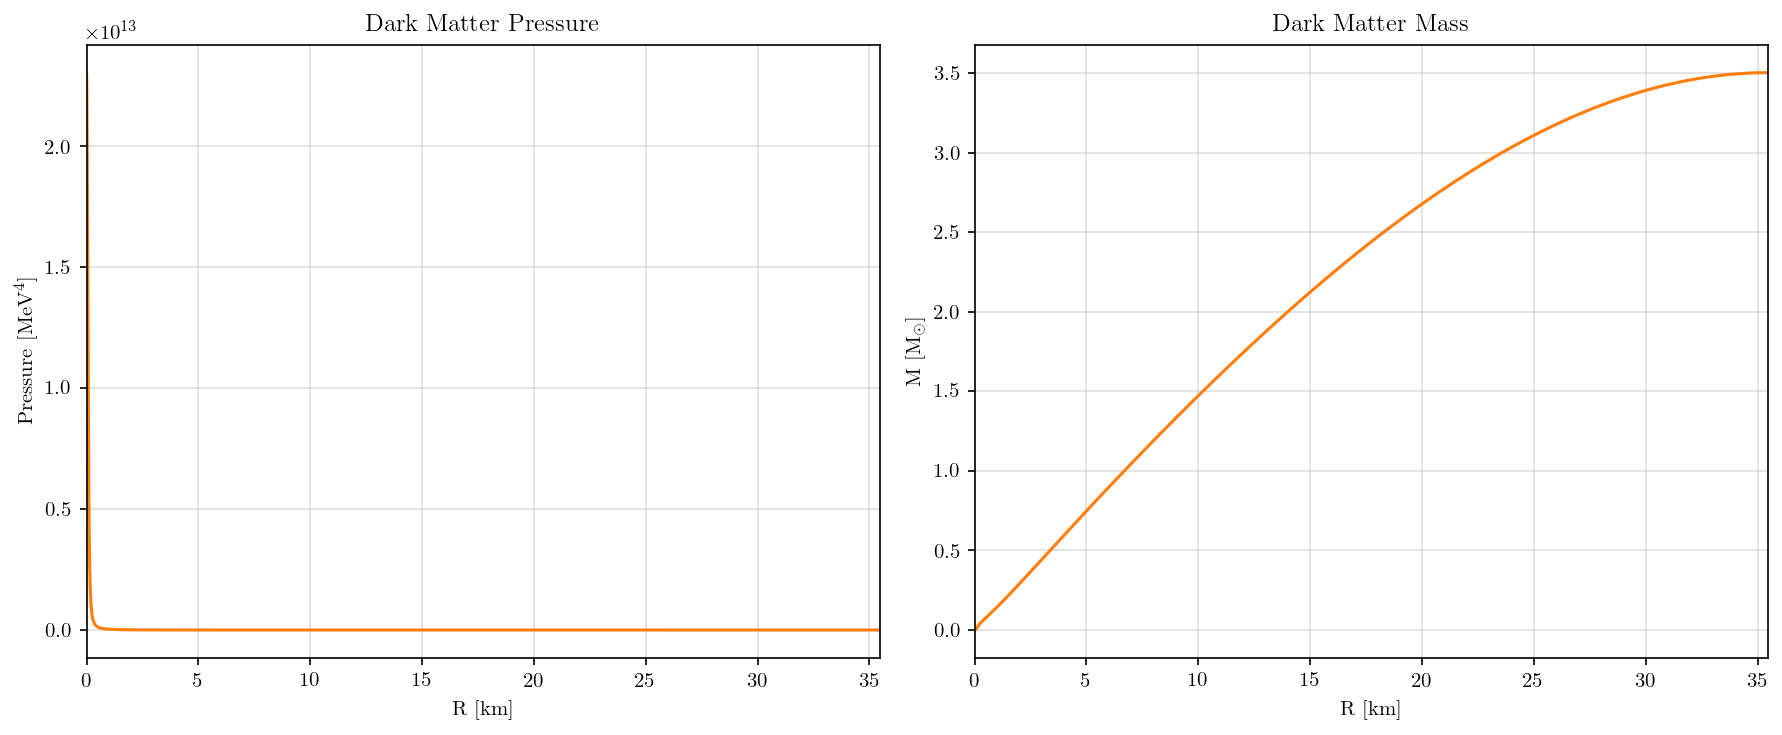

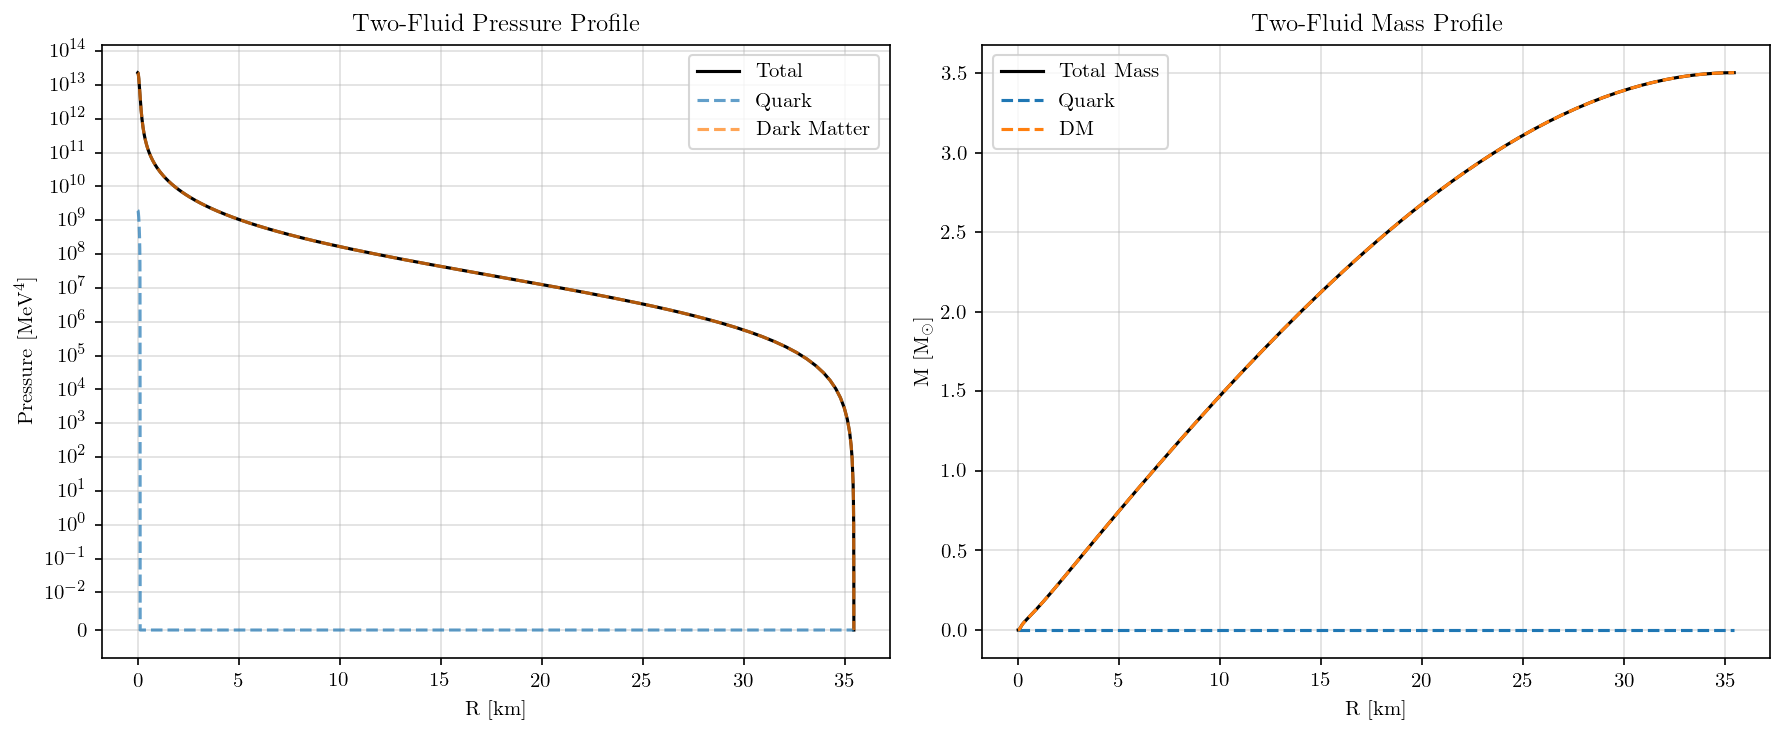

----- Final Results -----
Final Quark Radius: 0.1109 km
Final DM Radius:    35.4581 km
Total Mass:   3.5021 Solar Masses


In [103]:

# --- PLOTS ---

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Quark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlim(0, R_DM_final * factor_R_to_km)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
#plt.yscale('symlog', linthresh=1e-5) 
plt.title("Dark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlim(0, R_DM_final * factor_R_to_km)
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
plt.plot(R_km, P_total, label='Total', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2)

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM', color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Mass Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("----- Final Results -----")
print(f"Final Quark Radius: {R_quark_final * factor_R_to_km:.4f} km")
print(f"Final DM Radius:    {R_DM_final * factor_R_to_km:.4f} km")

# Print Final Physical Values
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")

If the boson mass is 200 MeV. The DM surface extends over the QM's. 

In [104]:
lamb = 1  # coupling strength
m_b = 1000 # MeV
n = 4

epsilon_0 = lamb * ( n / 2 - 1) * m_b ** n  # MeV^4
B = 145 **4 # MeV^4

def energy_density(pressure, n):
    return pressure ** (2/n) + ((n + 2) / (n - 2)) * pressure


grid_p_DM = np.logspace(-40, 15, int(1e5)) * epsilon_0 / (4* B)
grid_e_DM = energy_density(grid_p_DM, 4) * epsilon_0 / (4* B)

# ----------------------------------------------------
# 3. Solve
# ----------------------------------------------------

#Initial conditions
hc = 197.3269804 # MeV fm

r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, grid_e_quark, grid_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, grid_p_DM, grid_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

sol = solve_ivp(
    ode_TOV, 
    (r0, 1e15), 
    x0, 
    events=[event_Quark_surface, event_DM_surface, event_Stop_Integration],     # [0]=Quark, [1]=DM, [2]=Stop
    rtol=1e-8, 
    atol=1e-10,
    first_step=1e-7 
)

# ----------------------------------------------------
# 4. Solutions
# ----------------------------------------------------

r_adim = sol.t.copy()
p1_adim = sol.y[0].copy()
m1_adim = sol.y[1].copy()
p2_adim = sol.y[2].copy()
m2_adim = sol.y[3].copy()

# --- EXTRACT EXACT RADII FROM EVENTS ---
# sol.t_events is a list containing the R values for each event function.
# Index [0] corresponds to event_Quark_surface
# Index [1] corresponds to event_DM_surface

# 1. Quark Matter Handling
if len(sol.t_events[0]) > 0:
    R_quark_final = sol.t_events[0][0] # Take the first crossing
    print(f"Quark Surface detected at R = {R_quark_final:.4e}")
    
    # Clean up: Force pressure to 0 for all r > R_surface
    # This replaces the manual index search
    p1_adim[r_adim > R_quark_final] = 0.0
else:
    R_quark_final = None
    print("Quark pressure never crossed zero (or started at 0).")

# 2. Dark Matter Handling
if len(sol.t_events[1]) > 0:
    R_DM_final = sol.t_events[1][0] # Take the first crossing
    print(f"DM Surface detected at    R = {R_DM_final:.4e}")
    
    # Clean up: Force pressure to 0 for all r > R_surface
    p2_adim[r_adim > R_DM_final] = 0.0
else:
    R_DM_final = None
    print("DM pressure never crossed zero (or started at 0).")


# ----------------------------------------------------
# 5. Unit Conversions & Plotting
# ----------------------------------------------------
M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B


R_km = r_adim * factor_R_to_km
P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar
P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar


Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   2.21821676e+07
Central mass DM:     9.29164465e-11
Quark Surface detected at R = 1.9345e-01
DM Surface detected at    R = 1.0844e-03


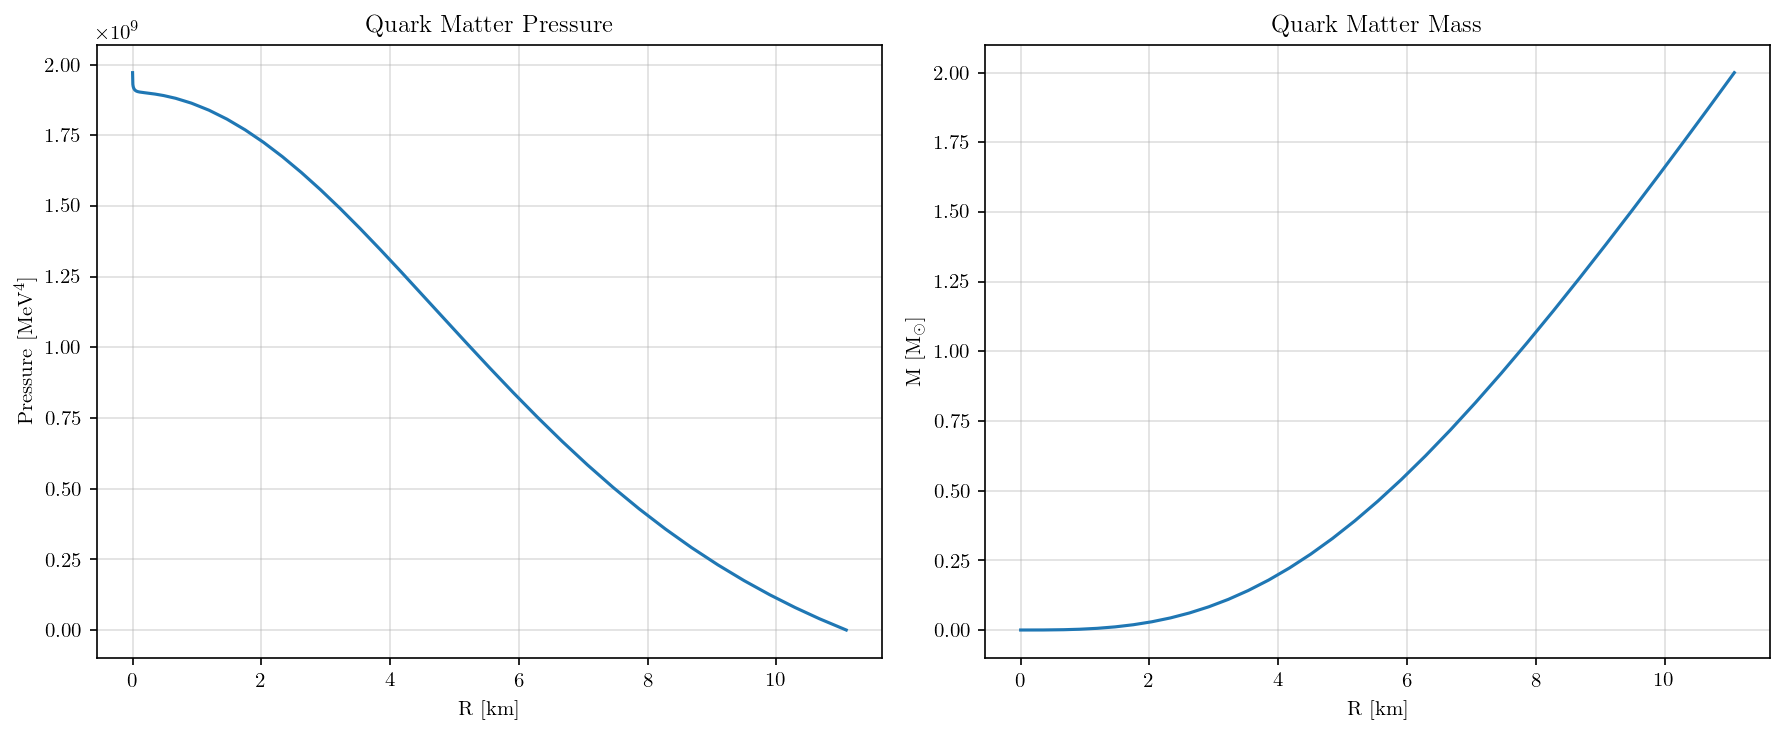

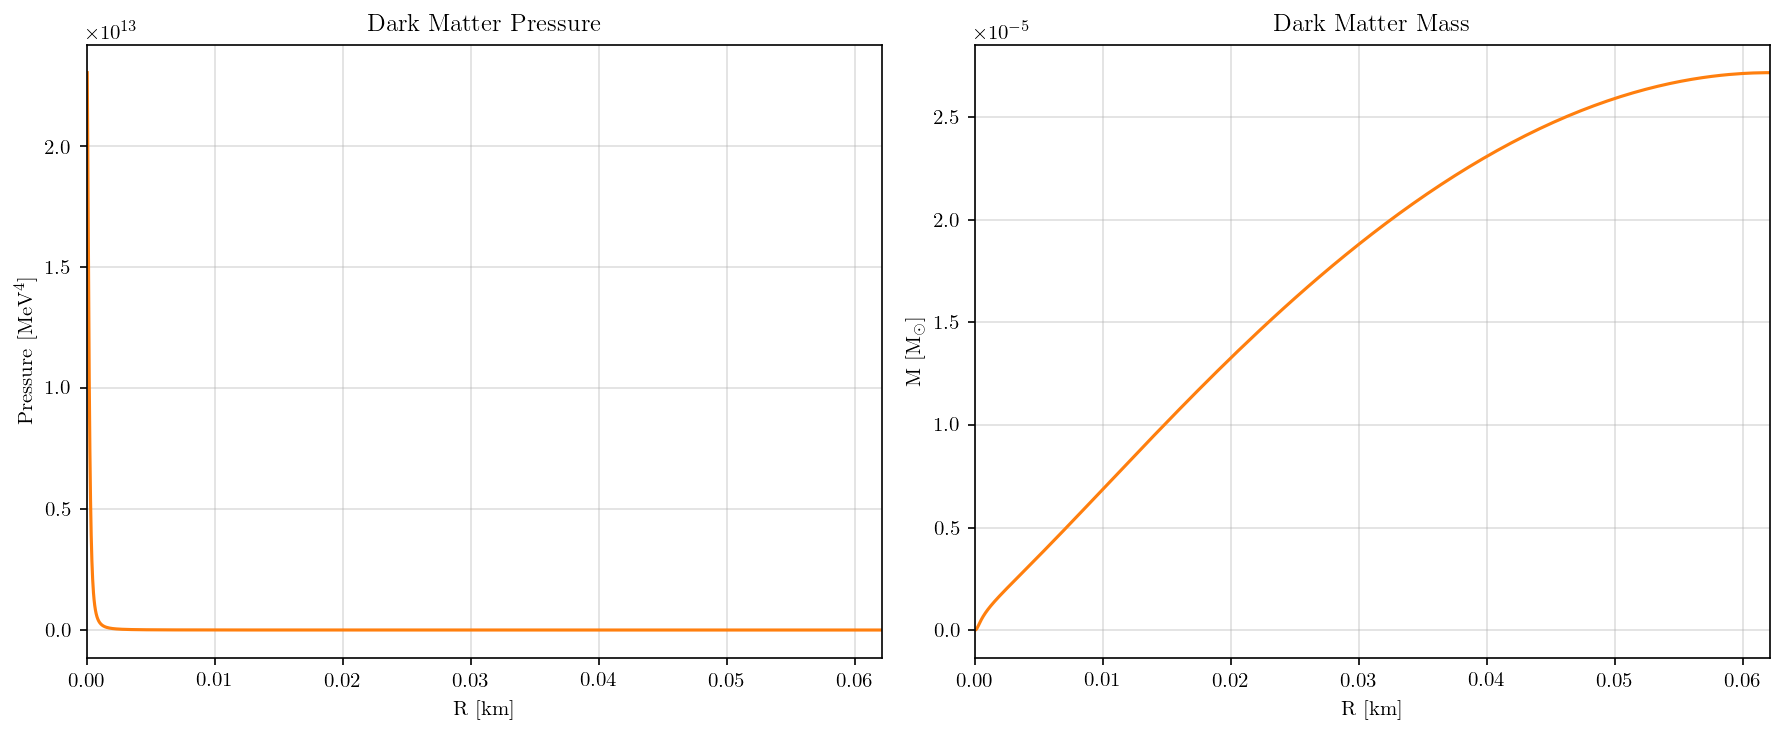

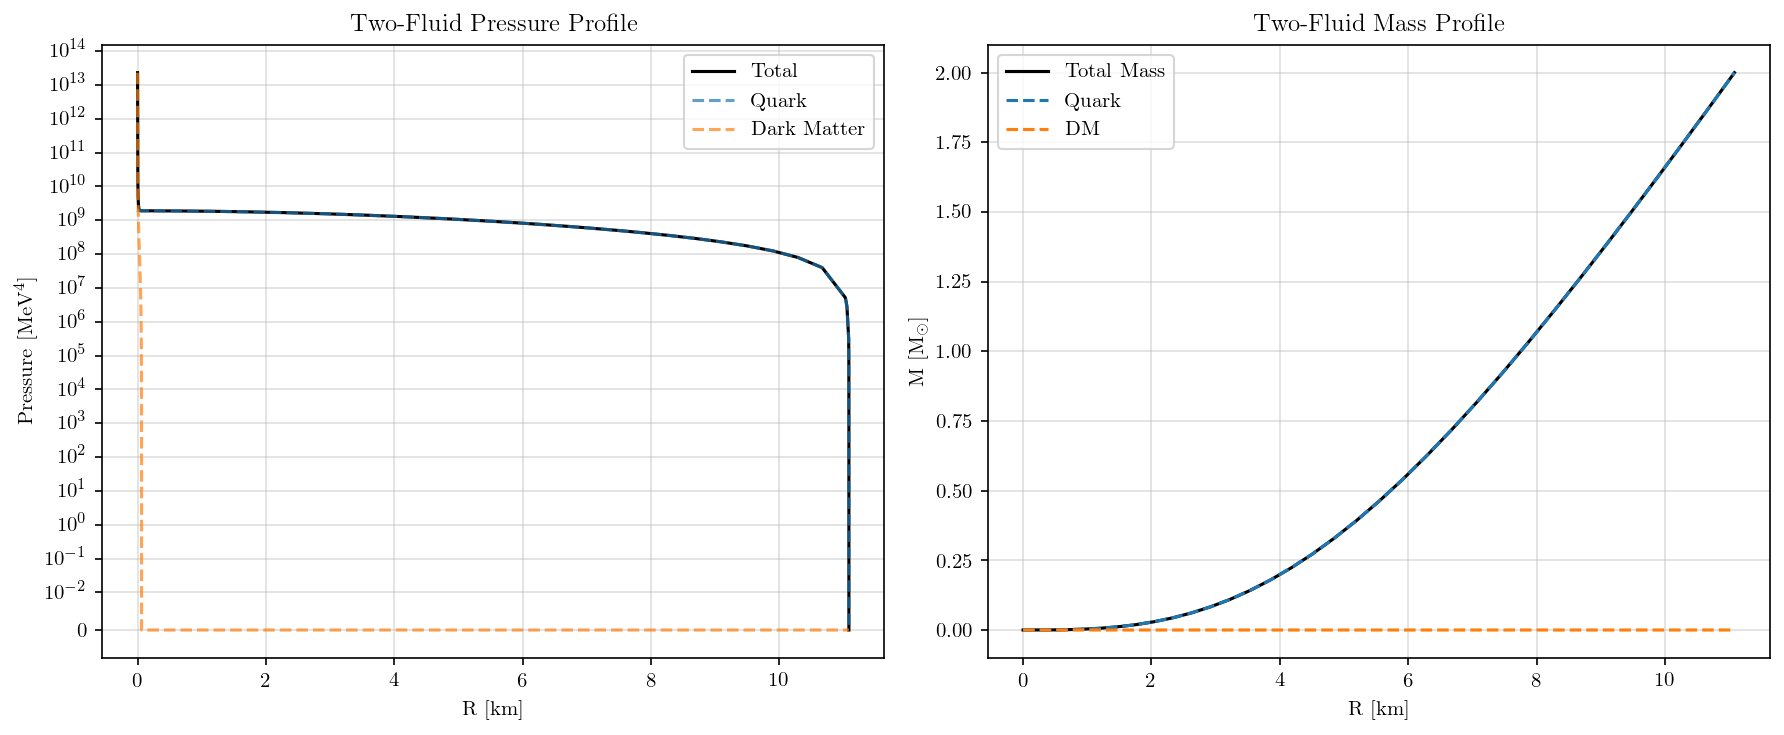

----- Final Results -----
Final Quark Radius: 11.0834 km
Final DM Radius:    0.0621 km
Total Mass:   2.0000 Solar Masses


In [105]:

# --- PLOTS ---

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Quark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlim(0, R_DM_final * factor_R_to_km)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
#plt.yscale('symlog', linthresh=1e-5) 
plt.title("Dark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlim(0, R_DM_final * factor_R_to_km)
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
plt.plot(R_km, P_total, label='Total', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2)

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM', color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Mass Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("----- Final Results -----")
print(f"Final Quark Radius: {R_quark_final * factor_R_to_km:.4f} km")
print(f"Final DM Radius:    {R_DM_final * factor_R_to_km:.4f} km")

# Print Final Physical Values
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")

For 1000 MeV, the QM extends over DM

In [106]:
lamb = 1  # coupling strength
m_b = 300 # MeV
n = 4

epsilon_0 = lamb * ( n / 2 - 1) * m_b ** n  # MeV^4
B = 145 **4 # MeV^4

def energy_density(pressure, n):
    return pressure ** (2/n) + ((n + 2) / (n - 2)) * pressure


grid_p_DM = np.logspace(-40, 15, int(1e5)) * epsilon_0 / (4* B)
grid_e_DM = energy_density(grid_p_DM, 4) * epsilon_0 / (4* B)

# ----------------------------------------------------
# 3. Solve
# ----------------------------------------------------

#Initial conditions
hc = 197.3269804 # MeV fm

r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, grid_e_quark, grid_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, grid_p_DM, grid_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

sol = solve_ivp(
    ode_TOV, 
    (r0, 1e15), 
    x0, 
    events=[event_Quark_surface, event_DM_surface, event_Stop_Integration],     # [0]=Quark, [1]=DM, [2]=Stop
    rtol=1e-8, 
    atol=1e-10,
    first_step=1e-7 
)

# ----------------------------------------------------
# 4. Solutions
# ----------------------------------------------------

r_adim = sol.t.copy()
p1_adim = sol.y[0].copy()
m1_adim = sol.y[1].copy()
p2_adim = sol.y[2].copy()
m2_adim = sol.y[3].copy()

# --- EXTRACT EXACT RADII FROM EVENTS ---
# sol.t_events is a list containing the R values for each event function.
# Index [0] corresponds to event_Quark_surface
# Index [1] corresponds to event_DM_surface

# 1. Quark Matter Handling
if len(sol.t_events[0]) > 0:
    R_quark_final = sol.t_events[0][0] # Take the first crossing
    print(f"Quark Surface detected at R = {R_quark_final:.4e}")
    
    # Clean up: Force pressure to 0 for all r > R_surface
    # This replaces the manual index search
    p1_adim[r_adim > R_quark_final] = 0.0
else:
    R_quark_final = None
    print("Quark pressure never crossed zero (or started at 0).")

# 2. Dark Matter Handling
if len(sol.t_events[1]) > 0:
    R_DM_final = sol.t_events[1][0] # Take the first crossing
    print(f"DM Surface detected at    R = {R_DM_final:.4e}")
    
    # Clean up: Force pressure to 0 for all r > R_surface
    p2_adim[r_adim > R_DM_final] = 0.0
else:
    R_DM_final = None
    print("DM pressure never crossed zero (or started at 0).")


# ----------------------------------------------------
# 5. Unit Conversions & Plotting
# ----------------------------------------------------
M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B


R_km = r_adim * factor_R_to_km
P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar
P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar


Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   1.79675558e+05
Central mass DM:     7.52623217e-13
Quark Surface detected at R = 4.4930e-03
DM Surface detected at    R = 1.2893e-01


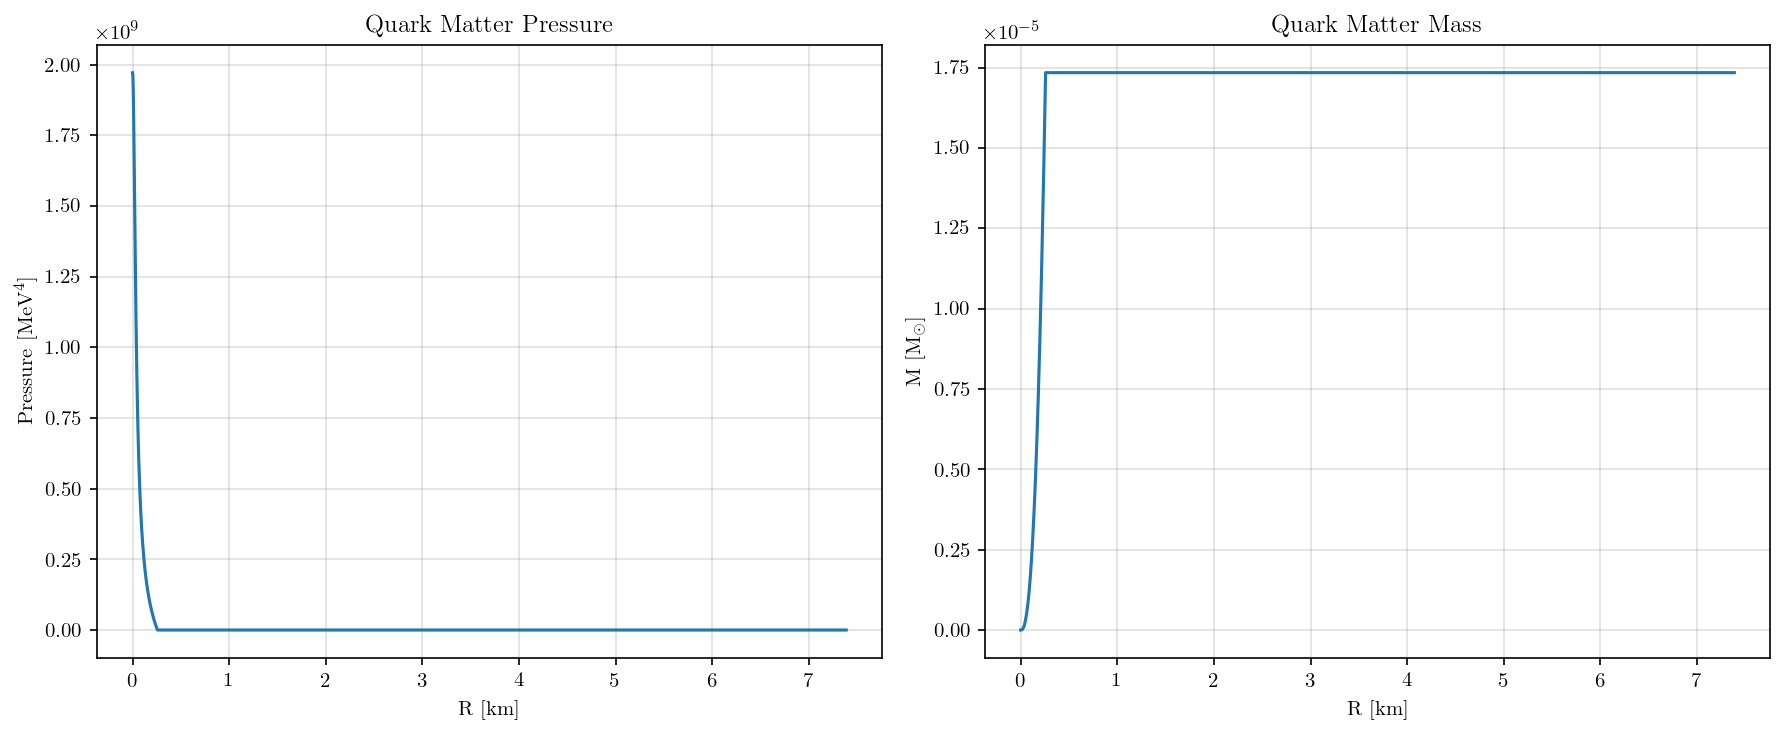

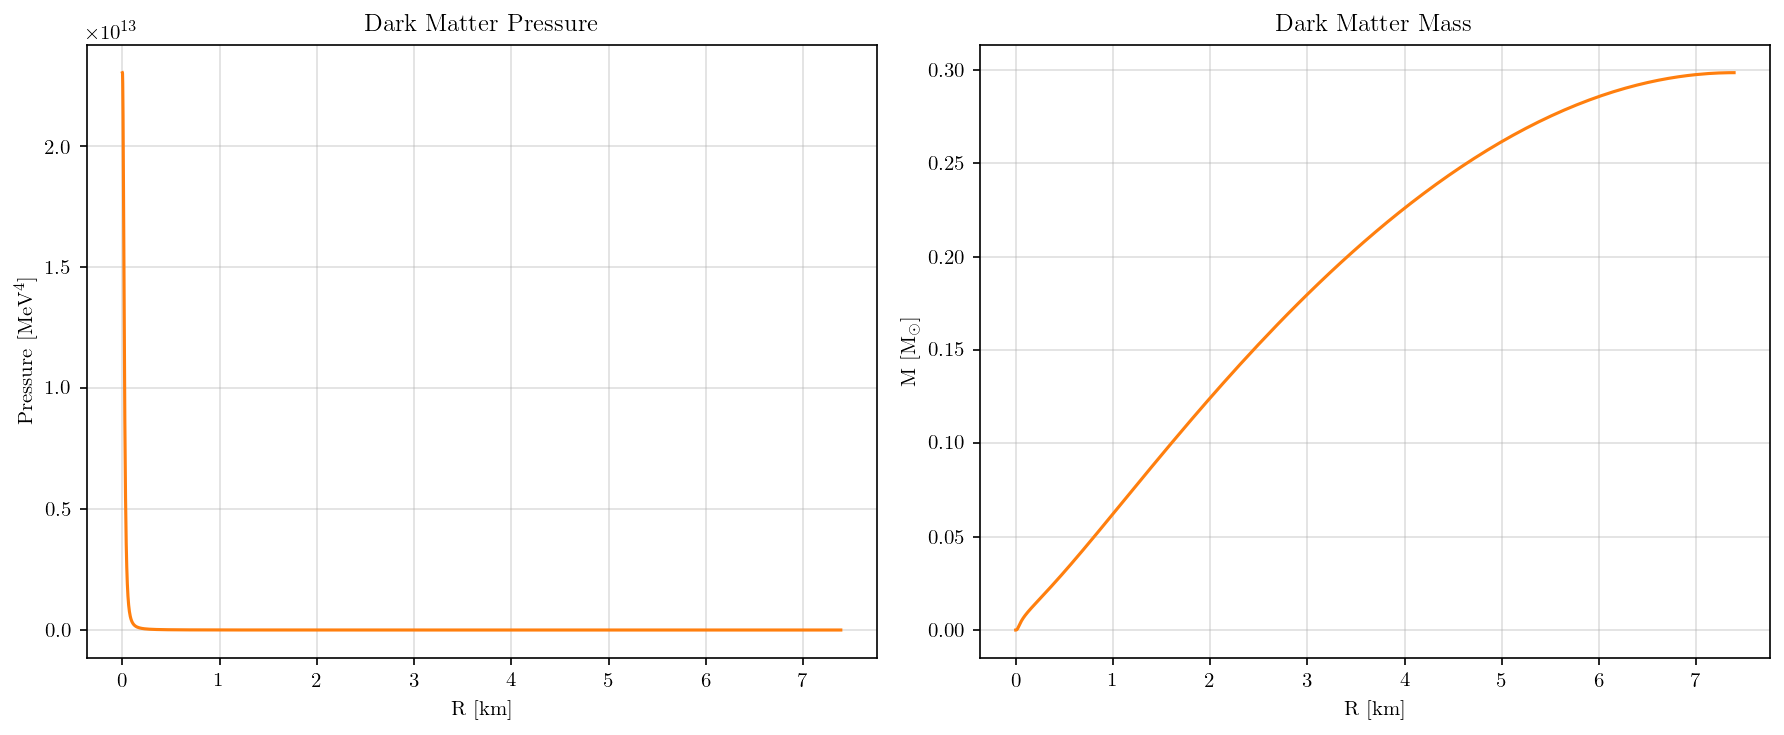

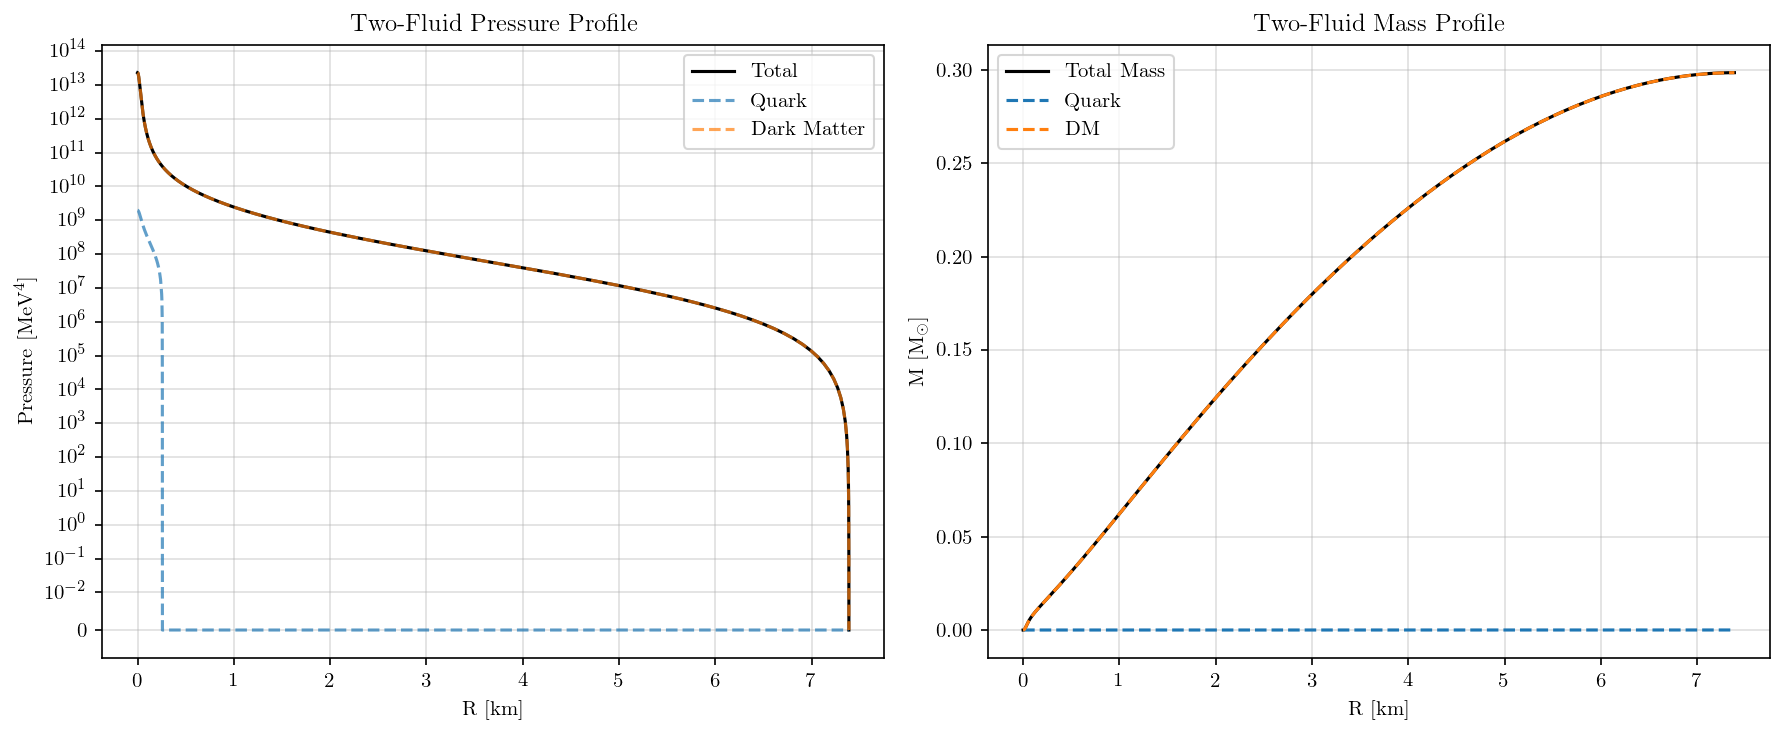

----- Final Results -----
Final Quark Radius: 0.2574 km
Final DM Radius:    7.3866 km
Total Mass:   0.2985 Solar Masses


In [107]:

# --- PLOTS ---

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Quark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Dark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
plt.plot(R_km, P_total, label='Total', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2)

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM', color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Mass Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("----- Final Results -----")
print(f"Final Quark Radius: {R_quark_final * factor_R_to_km:.4f} km")
print(f"Final DM Radius:    {R_DM_final * factor_R_to_km:.4f} km")

# Print Final Physical Values
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")

To continue with the exploration of the effect of changing the boson mass, I will repeat this for the same ICs

In [ ]:
def get_mass_radius_for_mb(m_b):
    lamb = 1  # coupling strength
    n = 4
    mb = m_b
    epsilon_0 = lamb * ( n / 2 - 1) * mb ** n  # MeV^4
    B = 145 **4 # MeV^4

    def energy_density(pressure, n):
        return pressure ** (2/n) + ((n + 2) / (n - 2)) * pressure


    grid_p_DM = np.logspace(-40, 15, int(1e5)) * epsilon_0 / (4 * B)
    grid_e_DM = energy_density(grid_p_DM, 4) * epsilon_0 / (4 * B)

    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2) # Treat negative pressure as 0 for physics

        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_DM, grid_e_DM)
        else:
            e2 = 0.0
        
        M = M1 + M2

        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        if term3 <= 1e-9: # negative or zero, horizon reached
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 (Quark)
        if p1 <= 0: # If raw pressure is negative, stop contribution
            dp1dr = -1.0
            dM1dr = 0.0 
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 (Dark Matter)
        if p2 <= 0: # If raw pressure is negative, stop contribution
            dp2dr = -1.0
            dM2dr = 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # 3. Solve
    # ----------------------------------------------------

    #Initial conditions
    hc = 197.3269804 # MeV fm

    r0 = 1e-6
    central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
    central_pressure_quark = np.interp(central_energy_quark, grid_e_quark, grid_p_quark)
    central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

    central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
    central_energy_DM = np.interp(central_pressure_DM, grid_p_DM, grid_e_DM)
    central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


    x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e15), 
        x0, 
        events=[event_Quark_surface, event_DM_surface, event_Stop_Integration],     # [0]=Quark, [1]=DM, [2]=Stop
        rtol=1e-8, 
        atol=1e-10,
        first_step=1e-7 
    )

    # ----------------------------------------------------
    # 4. Solutions
    # ----------------------------------------------------

    r_adim = sol.t.copy()
    p1_adim = sol.y[0].copy()
    m1_adim = sol.y[1].copy()
    p2_adim = sol.y[2].copy()
    m2_adim = sol.y[3].copy()

    # --- EXTRACT EXACT RADII FROM EVENTS ---
    # sol.t_events is a list containing the R values for each event function.
    # Index [0] corresponds to event_Quark_surface
    # Index [1] corresponds to event_DM_surface

    # 1. Quark Matter Handling
    if len(sol.t_events[0]) > 0:
        R_quark_final = sol.t_events[0][0] # Take the first crossing
        print(f"Quark Surface detected at R = {R_quark_final:.4e} for m_b = {m_b} MeV")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        # This replaces the manual index search
        p1_adim[r_adim > R_quark_final] = 0.0
    else:
        R_quark_final = None
        print("Quark pressure never crossed zero (or started at 0).")

    # 2. Dark Matter Handling
    if len(sol.t_events[1]) > 0:
        R_DM_final = sol.t_events[1][0] # Take the first crossing
        print(f"DM Surface detected at    R = {R_DM_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        p2_adim[r_adim > R_DM_final] = 0.0
    else:
        R_DM_final = None
        print("DM pressure never crossed zero (or started at 0).")


    # ----------------------------------------------------
    # 5. Unit Conversions & Plotting
    # ----------------------------------------------------
    M_p = 1.2209e22  # MeV
    mev_to_kg = 1.78266192e-30 
    msun_kg = 1.98847e30

    factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
    factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg



    M1_phys = m1_adim * factor_M_to_Solar
    M2_phys = m2_adim * factor_M_to_Solar

    M_total = M1_phys + M2_phys

    results = {
        "R_quark": R_quark_final * factor_R_to_km,
        "R_dm": R_DM_final * factor_R_to_km ,
        "M_total": M_total[-1]
    }
    return results


In [114]:
boson_mass = np.linspace(100,1000, 10)
mass_radius_results = []

for m_b in boson_mass:
    result = get_mass_radius_for_mb(m_b)
    mass_radius_results.append({
        "m_b": m_b,
        "R_quark": result["R_quark"] ,
        "R_dm": result["R_dm"],
        "M_total": result["M_total"]
    })

Quark Surface detected at R = 2.4538e-03
DM Surface detected at    R = 9.0687e+00
Quark Surface detected at R = 1.9350e-03
DM Surface detected at    R = 6.1889e-01
Quark Surface detected at R = 4.4930e-03
DM Surface detected at    R = 1.2893e-01
Quark Surface detected at R = 1.8229e-01
DM Surface detected at    R = 3.4683e-02
Quark Surface detected at R = 1.9825e-01
DM Surface detected at    R = 1.4939e-02
Quark Surface detected at R = 1.9641e-01
DM Surface detected at    R = 7.6349e-03
Quark Surface detected at R = 1.9498e-01
DM Surface detected at    R = 4.2931e-03
Quark Surface detected at R = 1.9418e-01
DM Surface detected at    R = 2.5824e-03
Quark Surface detected at R = 1.9372e-01
DM Surface detected at    R = 1.6377e-03
Quark Surface detected at R = 1.9345e-01
DM Surface detected at    R = 1.0844e-03


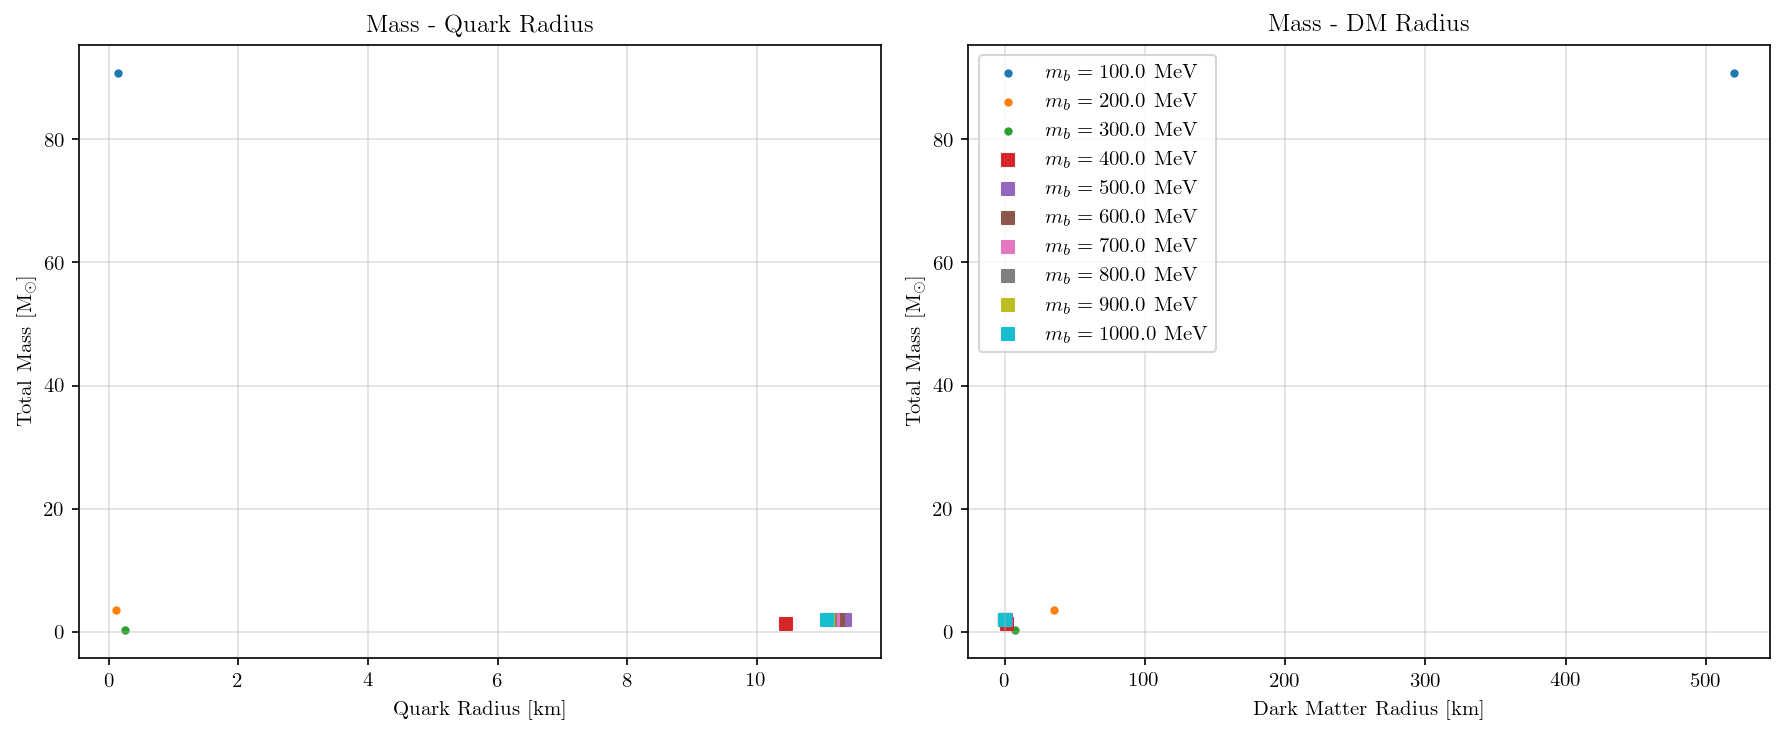

In [122]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

for res in mass_radius_results:
    if res["R_quark"] > res["R_dm"]: # Quark matter dominates
        plt.scatter(res["R_quark"], res["M_total"], label=f"$m_b$={res['m_b']:.1f} MeV", marker = 's')
    else: # DM dominates
        plt.scatter(res["R_quark"], res["M_total"], label=f"$m_b$={res['m_b']:.1f} MeV", marker = '.')
plt.xlabel(" Quark Radius [km]")
plt.ylabel("Total Mass [M$_\odot$]")
plt.title("Mass - Quark Radius ")
plt.grid(True)

plt.subplot(1,2,2)
for res in mass_radius_results:
    if res["R_dm"] > res["R_quark"]:
        plt.scatter(res["R_dm"], res["M_total"], label=f"$m_b={res['m_b']:.1f}$ MeV", marker = '.')
    else:
        plt.scatter(res["R_dm"], res["M_total"], label=f"$m_b={res['m_b']:.1f}$ MeV", marker = 's')
plt.xlabel(" Dark Matter Radius [km]")
plt.ylabel("Total Mass [M$_\odot$]")
plt.title("Mass - DM Radius")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()







Apparently the results of $m_b=100$ MeV are very different, and not compatible with a neutron star. Witout them:

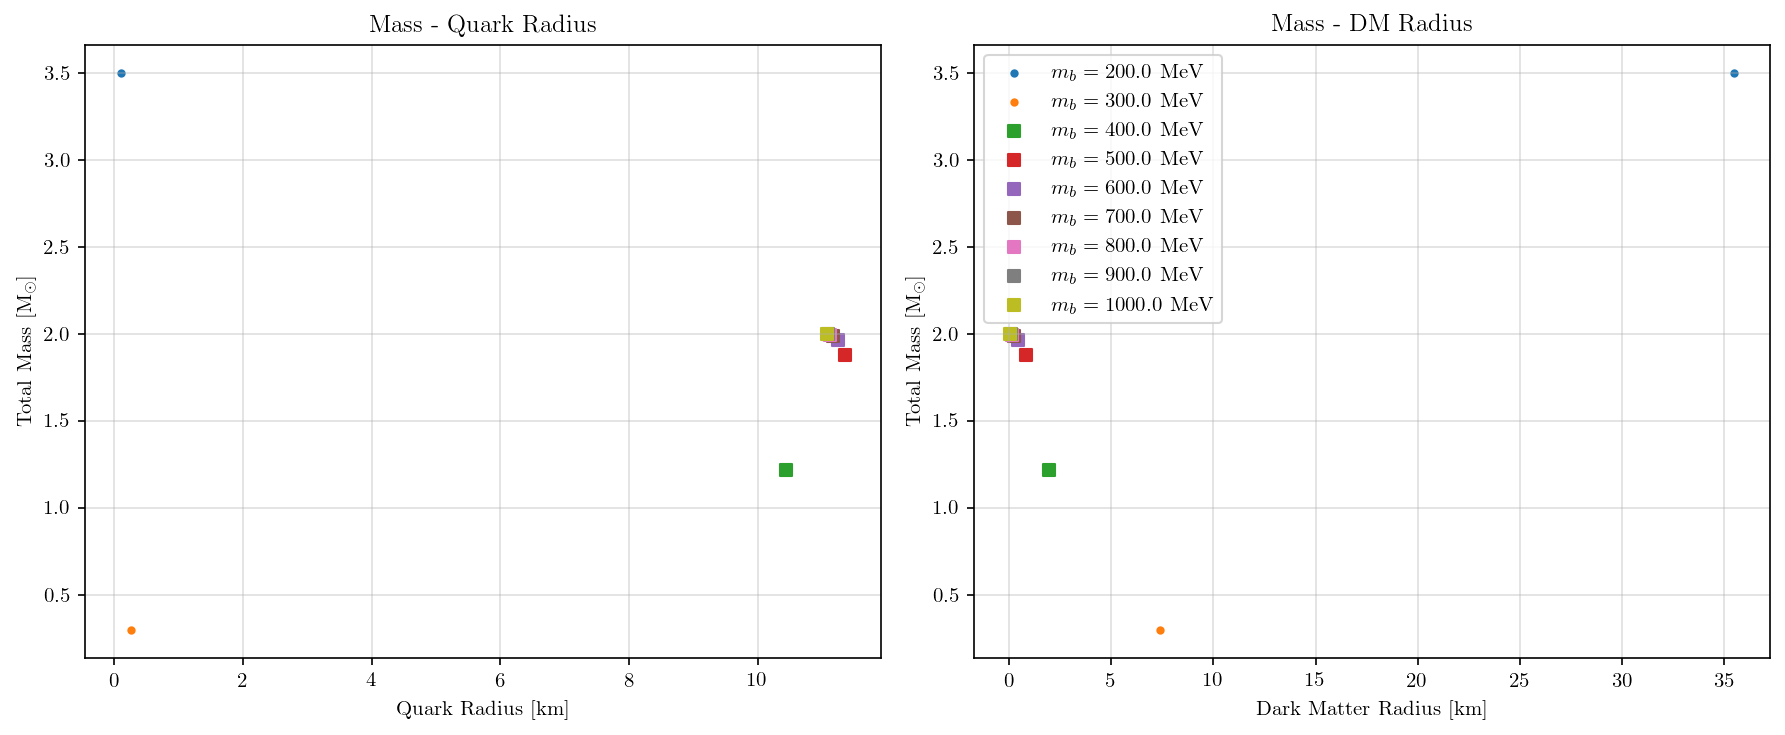

In [123]:
# Without mb = 100 MeV
filtered_results = [res for res in mass_radius_results if res['m_b'] != 100]


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

for res in filtered_results:
    if res["R_quark"] > res["R_dm"]: # Quark matter dominates
        plt.scatter(res["R_quark"], res["M_total"], label=f"$m_b$={res['m_b']:.1f} MeV", marker = 's')
    else: # DM dominates
        plt.scatter(res["R_quark"], res["M_total"], label=f"$m_b$={res['m_b']:.1f} MeV", marker = '.')
plt.xlabel(" Quark Radius [km]")
plt.ylabel("Total Mass [M$_\odot$]")
plt.title("Mass - Quark Radius ")
plt.grid(True)

plt.subplot(1,2,2)
for res in filtered_results:
    if res["R_dm"] > res["R_quark"]:
        plt.scatter(res["R_dm"], res["M_total"], label=f"$m_b={res['m_b']:.1f}$ MeV", marker = '.')
    else:
        plt.scatter(res["R_dm"], res["M_total"], label=f"$m_b={res['m_b']:.1f}$ MeV", marker = 's')
plt.xlabel(" Dark Matter Radius [km]")
plt.ylabel("Total Mass [M$_\odot$]")
plt.title("Mass - DM Radius")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


Squares are Quark Matter dominated (meaning the radius of QM is larger than DM, that is a core)